Преамбула. Здесь подключаются необходимые библиотеки.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture

from copy import deepcopy
from time import sleep
from matplotlib.colors import to_rgba
from IPython.display import clear_output

In [2]:
plt.rcParams['figure.figsize'] = (12, 6)

colors = ['blue', 'green', 'red']

## Теоретические сведения

Пусть $X$ и $Y$ -- случайные величины, заданные на одном вероятностном пространстве $(\Omega, \mathcal{A})$.

* $X$ -- реально наблюдаемые данные;
* $Y$ -- ненаблюдаемые (скрытые) переменные.

Введем плотности распределений:
* $f_\theta(x, y),~ x, y \in \mathbb{R}$ -- совместное распределение с.в. $X$ и $Y$.
* $f_\theta^X(x),~x\in\mathbb{R}$ -- маргинальное распределение с.в. $X$.
* $f_\theta^Y(y),~y\in\mathbb{R}$ -- маргинальное распределение с.в. $Y$.

Рассмотрим конечную сдвиг-масштабную смесь: $$f_\theta^X(x) = \sum\limits_{i=1}^{k} \frac{p_i}{\sigma_i} \varphi\left(\frac{x - \mu_i}{\sigma_i}\right), \quad x \in \mathbb{R}, \sigma_i > 0$$
$$ f_\theta^Y(i) := \mathsf{P}(Y = i) = p_i, \quad i = \overline{1,k}, \sum\limits_{i=1}^k p_i = 1,$$
где $\varphi(x) = \frac{1}{\sqrt{2\pi}} e ^ {-x^2/2}, x\in\mathbb{R}$ -- плотность распределения стандартного нормального закона.

В этой модели считается, что сначала выбирается нормальная компонента $i \in {1, \ldots, k}$ (значение с.в. $Y$), а затем из этой компоненты генерируется наблюдение $X$ (то есть $X$ взято из нормального распределения $\mathcal{N}(\mu_i, \sigma_i^2)$). Формально, **условное распределение с.в. $X$ при условии $Y = i$ является нормальным с параметрами $\mu_i$ и $\sigma_i^2$.**

Параметром $\theta$ в такой модели является $3k$-мерный вектор: $$\theta = (p_1,\ldots,p_k, \mu_1, \ldots, \mu_k, \sigma_1, \ldots, \sigma_k).$$

С учетом того, что $\sum_{i=1}^k p_i = 1$ необходимо настроить $3k-1$ параметр.

### EM-алгоритм для конечной сдвиг-масштабной нормальной смеси
Классическим методом поиска **оценки максимального правдоподобия** для такой модели является **EM-алгоритм**. Он представляет собой итерационный алгоритм, строящий последовательность $\{\theta^{(m)}\}$, сходящуюся к точке максимального правдоподобия $\theta_{ML}$.

Каждая итерация алгоритма состоит из двух шагов:

* **E-шаг (Expectation):** используя оценку предыдущего шага $\theta^{(m)}$, пересчитываются параметры $(p_1^{(m+1)}, \ldots, p_k^{(m+1)})$ скрытой с.в. $Y$.
* **M-шаг (Maximization):** при зафиксированных параметрах $(p_1^{(m+1)}, \ldots, p_k^{(m+1)})$ скрытой с.в. $Y$, вычисляется оценка *максимального правдоподобия* $(\mu_1^{(m+1)}, \ldots, \mu_k^{(m+1)}, \left(\sigma_1^{(m+1)}\right)^2, \ldots, \left(\sigma_k^{(m+1)}\right)^2)$ параметров наблюдаемой с.в. $X$.

Пусть у нас $n$ наблюдений за случайной величиной $X$: $(x_1, \ldots, x_n)$. 

В этом случае формулы вычисления оценки на $m$-ой итерации шага для конечной сдвиг-масштабной смеси нормальных законов: 
$$p_i^{(m+1)} = \frac{1}{n} \sum\limits_{j=1}^{n} g_{ij}^{(m)}, \quad \mu_i^{(m+1)} = \sum\limits_{j=1}^{n} x_j g_{ij}^{(m)} \big/ \sum\limits_{j=1}^{n} g_{ij}^{(m)},$$
$$(\sigma_i^{(m+1)})^2 = \sum\limits_{j=1}^{n} \left(x_j - \mu_i^{(m+1)}\right)^2 g_{ij}^{(m)} \big/ \sum\limits_{j=1}^{n} g_{ij}^{(m)}, \quad i = \overline{1, k},$$
где $$g_{ij}^{(m)} = \frac{\tfrac{p_i^{(m)}}{\sigma_i^{(m)}} \varphi\Big(\frac{x_j - \mu_i^{(m)}}{\sigma_i^{(m)}}\Big)}{\sum_{r=1}^k \tfrac{p_r^{(m)}}{\sigma_r^{(m)}} \varphi\Big(\frac{x_j - \mu_r^{(m)}}{\sigma_r^{(m)}}\Big)}, \quad i=\overline{1,k}, j=\overline{1,n}.$$

Имея оценку параметров $\theta$, можно вычислить предсказательное распределение:
$$\mathsf{P}(Y = i|X = x) = \frac{\tfrac{p_i}{\sigma_i} \varphi\big(\frac{x - \mu_i}{\sigma_i}\big)}{\sum_{r=1}^k \tfrac{p_r}{\sigma_r} \varphi\Big(\frac{x - \mu_r}{\sigma_r}\Big)}, \quad x \in \mathsf{R}, i=\overline{1,k}.$$

In [3]:
class GaussianMixtureModel:
    def __init__(self, k, max_iter=8192, tol=1e-3):
        self.k = k
        self.max_iter = max_iter
        self.tol = tol
        
        self._is_fitted = False
        return

    def fit(self, X, y=None):        
        # превращаем данные в одномерный массив
        X = np.array(X)
        self.X_ = X
        
        # проверяем, что на вход переданы данные
        # правильной размерности
        assert len(X.shape) == 1 or X.shape[1] == 1, 'X must be 1-d vector of shape (N,) or (N, 1)'
        
        # превратим данные X в вектор размера (N, )
        X = np.array(X).reshape(-1,) 
        
        # инициализируем параметры
        # p -- установим одинаковыми с вероятностями 1 / k
        p = np.ones(self.k) / self.k
        mu = X.mean() + np.random.normal(size=self.k)
        sigma = np.ones(self.k)
        
        self.trace_ = [(p, mu, sigma)]
        
        # EM-алгоритм
        for it in range(self.max_iter):
            # E-шаг
            # необходимо посчитать новые вероятности p скрытого распределения            
            eps = 1e-7 * np.isclose(sigma[:, None], 0)
            g = (X[None] - mu[:, None]) / (np.sqrt(sigma[:, None]) + eps)
            g = np.exp(-np.power(g, 2) / 2) / np.sqrt(2 * np.pi)
            g = p[:, None] * g / (np.sqrt(sigma[:, None]) + eps)
            g = g / g.sum(axis=0, keepdims=True)            
            
            gs = g.sum(axis=1)
            p_ = g.mean(axis=1)
            
            assert p_.shape == (self.k, ), f'Shape of p_ must be ({self.k},)'
            
            # M-шаг
            # теперь надо посчитать новые mu и sigma
            mu_ = (X[None] * g).sum(axis=1) / gs
            sigma_ = (np.power(X[None] - mu_[:, None], 2) * g).sum(axis=1) / gs
            
            assert mu_.shape == (self.k,), f'Shape of mu_ must be ({self.k},)'
            assert sigma_.shape == (self.k,), f'Shape of sigma_ must be ({self.sigma},)'
            
            # условие выхода 
            theta = np.concatenate([p.flatten(), mu.flatten(), sigma.flatten()])
            theta_ = np.concatenate([p_.flatten(), mu_.flatten(), sigma_.flatten()])
            
            if np.abs(theta - theta_).max() < self.tol:
                break
            
            p, mu, sigma = p_, mu_, sigma_
            self.trace_.append([p, mu, sigma])
            # конец итерации
        
        # устанавливаем настроенные параметры
        idx = np.argsort(mu_)
        
        self.p_ = p_[idx]
        self.mu_ = mu_[idx]
        self.sigma_ = sigma_[idx]
        
        self.trace_ = [[x[idx] for x in row] for row in self.trace_]
        
        self.iterations_ = len(self.trace_)
        
        # модель настроена
        self._is_fitted = True
        return self
    
# метод pdf, который считает плотность распределения
    def pdf(self, x, k=None):
        if k is None:
            p = self.p_
        else:
            p = np.zeros_like(self.p_)
            p[k] = self.p_[k]
        
        eps = 1e-6 * np.isclose(self.sigma_,0)
        x = (x - self.mu_) / np.sqrt(self.sigma_ + eps)
        x = np.exp(-np.power(x, 2) / 2) / (np.sqrt(2 * np.pi) * (np.sqrt(self.sigma_) + eps))
        return (x * p).sum()
    
# метод predict, который предсказывает номер компоненты
# из которой пришло распределение
    def predict(self, x):
        eps = 1e-6 * np.isclose(self.sigma_,0)
        g = (x - self.mu_) / np.sqrt(self.sigma_)
        g = np.exp(-np.power(g, 2) / 2) / (np.sqrt(2 * np.pi) * (np.sqrt(self.sigma_) + eps))
        g = g * self.p_
        return g / g.sum()

## Пример: синтетические данные

In [4]:
def generate():
    p = [0.4, 0.35, 0.25]
    mu = [-3, 0, 3]
    sigma = np.sqrt([0.5, 1, 0.2])
    
    y = np.random.choice(len(p), p=p)
    x = np.random.normal(loc=mu[y], scale=sigma[y])
    return x

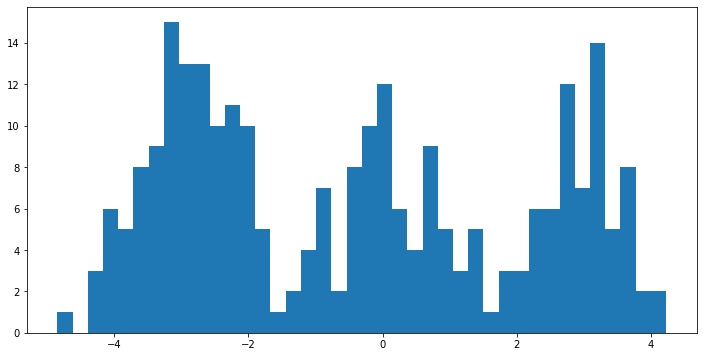

In [5]:
np.random.seed(42)
N = 256

X = np.array([generate() for _ in range(N)])
plt.hist(X, bins=40)
plt.show()

In [6]:
gmm = GaussianMixtureModel(3)
gmm.fit(X)

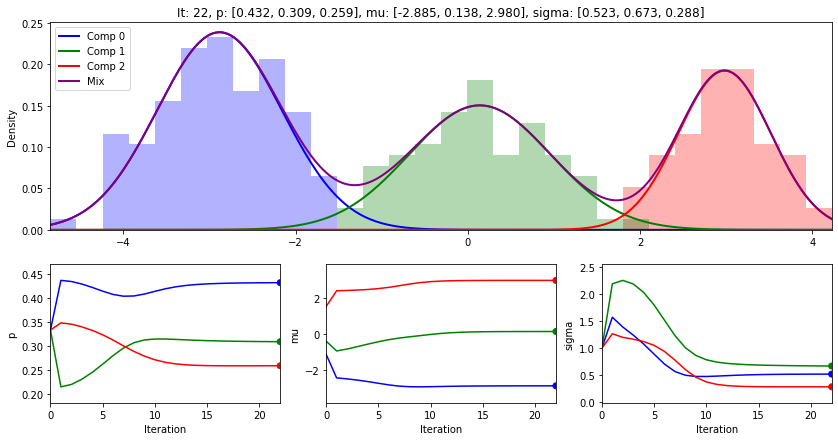

In [7]:
def plot_gmm(gmm, step=None, n_steps=None, pdf_max=None):
    p_trace, mu_trace, sigma_trace = map(np.array, zip(*gmm.trace_))
    n_steps = n_steps if n_steps is not None else gmm.iterations_
    step = step if step is not None else (n_steps - 1)
    
    fig, axs = plt.subplots(2, 3, figsize=(14, 7), gridspec_kw={'height_ratios': [3, 2]})
    gs = axs[1, 2].get_gridspec()
    
    colors = ['blue', 'green', 'red']
    
    for a in axs[0]:
        a.remove()
    ax_pdf = fig.add_subplot(gs[0, :])    
    
    ax = axs[1].flatten()
    for a in list(ax) + [ax_pdf]:
        a.set_prop_cycle(color=colors) 
    
    p, mu, sigma = gmm.trace_[step]
    
    ax[0].plot(p_trace[:step + 1])
    ax[0].scatter(np.ones_like(p) * step, p, c=colors)
    
    ax[1].plot(mu_trace[:step + 1])
    ax[1].scatter(np.ones_like(mu) * step, mu, c=colors)
    
    ax[2].plot(sigma_trace[:step + 1])
    ax[2].scatter(np.ones_like(sigma) * step, sigma, c=colors)
    
    for a in ax:
        a.set_xlabel('Iteration')
        a.set_xbound(0, n_steps - 1)

    ax[0].set_ylabel('p')
    ax[1].set_ylabel('mu')
    ax[2].set_ylabel('sigma')
    for a, t in zip(ax, [p_trace, mu_trace, sigma_trace]):
        low, high = t.min(), t.max()
        delta = high - low
        a.set_ybound(low - delta * 0.15, high + delta * 0.15)

    gmm_demo = deepcopy(gmm)
    gmm_demo.p_ = p
    gmm_demo.mu_ = mu
    gmm_demo.sigma_ = sigma

    X = gmm_demo.X_
    y = np.array([gmm_demo.predict(x).argmax() for x in X])
    
    palette = list(np.array(colors)[np.unique(y)])
    sns.histplot(x=X, hue=y, bins=30, stat='density', alpha=0.3, linewidth=0,
                 palette=palette, legend=False, ax=ax_pdf)
    
    
    x_plt = np.linspace(X.min(), X.max(), 256)
    for k in range(3):
        y_plt = np.array([gmm_demo.pdf(x, k=k) for x in x_plt])
        ax_pdf.plot(x_plt, y_plt, lw=2, label=f'Comp {k}')

    y_plt = np.array([gmm_demo.pdf(x) for x in x_plt])
    ax_pdf.plot(x_plt, y_plt, color='purple', lw=2, label='Mix')
    ax_pdf.set_xbound(X.min(), X.max())
    ax_pdf.set_ybound(upper=pdf_max)

    fmt = lambda x: f'[{{}}]'.format(', '.join(f'{_:.3f}' for _ in x))
    ax_pdf.set_title(f'It: {step}, p: {fmt(p)}, mu: {fmt(mu)}, sigma: {fmt(sigma)}')
    ax_pdf.legend()
    plt.show()
    
def plot_animation(gmm, n_steps=None, frames_to_skip=0, pdf_max=None):
    frames_to_skip += 1
    steps = list(range(0, gmm.iterations_, frames_to_skip))
    if steps[-1] != gmm.iterations_ - 1:
        steps.append(gmm.iterations_ - 1)
    for step in steps:
        clear_output(wait=True)
        plot_gmm(gmm, step, n_steps=n_steps, pdf_max=pdf_max)
    
plot_gmm(gmm)

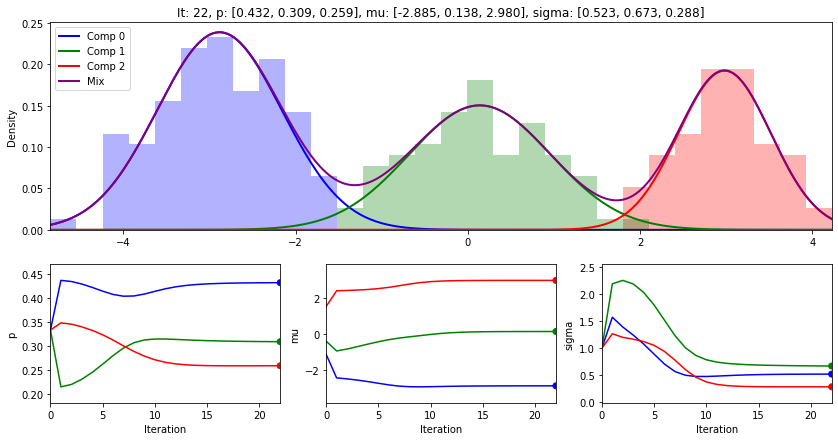

In [8]:
plot_animation(gmm, frames_to_skip=0)

## Sklearn:

In [9]:
from sklearn.mixture import GaussianMixture


gmm_sklearn = GaussianMixture(n_components=3)
gmm_sklearn.fit(X.reshape(-1, 1))

print(gmm.p_, gmm.mu_, gmm.sigma_)
print(gmm_sklearn.weights_, gmm_sklearn.means_.squeeze(), gmm_sklearn.covariances_.squeeze())

[0.43247407 0.30884963 0.2586763 ] [-2.88470877  0.13790334  2.98002123] [0.52327384 0.67180094 0.28837352]
[0.30266091 0.43423398 0.26310511] [ 0.12356668 -2.88016833  2.96139698] [0.61683803 0.52700092 0.30636645]


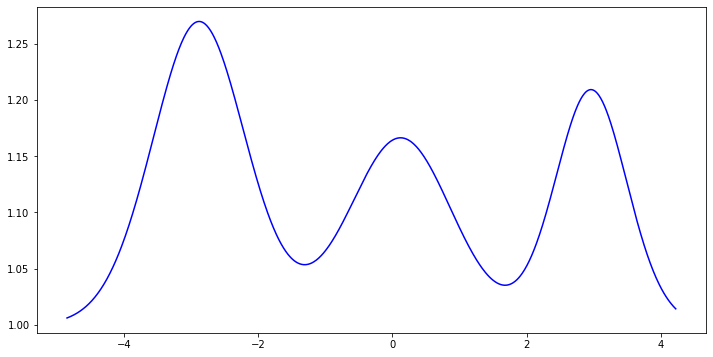

In [10]:
# pdf
x_plt = np.linspace(X.min(), X.max(), 1024)
pdf_sklearn = np.exp(gmm_sklearn.score_samples(x_plt.reshape(-1, 1)))

plt.plot(x_plt, np.exp(pdf_sklearn), color='blue');

### Пример: ирисы Фишера

In [11]:
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


<AxesSubplot:xlabel='petal_length', ylabel='Count'>

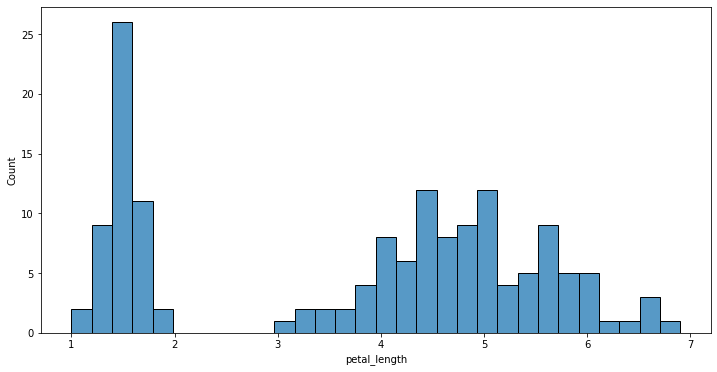

In [12]:
sns.histplot(data=iris, x='petal_length', bins=30)

In [13]:
X = iris.petal_length.values

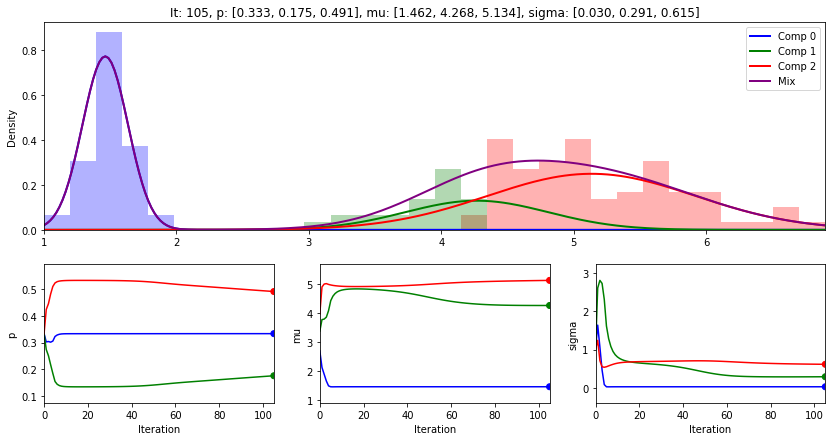

In [14]:
gmm = GaussianMixtureModel(k=3)
gmm.fit(X)

plot_animation(gmm, frames_to_skip=5)

## Многомерный случай

In [15]:
X = iris[['petal_length', 'petal_width']].values
y = LabelEncoder().fit_transform(iris.species)

X[:5], y[:5]

(array([[1.4, 0.2],
        [1.4, 0.2],
        [1.3, 0.2],
        [1.5, 0.2],
        [1.4, 0.2]]),
 array([0, 0, 0, 0, 0]))

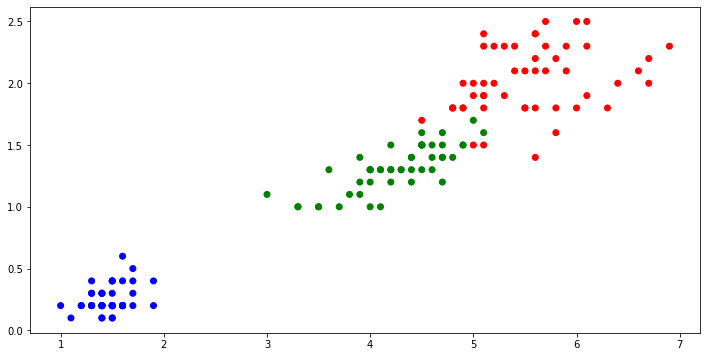

In [16]:
plt.scatter(iris.petal_length, iris.petal_width, c=list(np.array(colors)[y]))
plt.show()

Обучим Gaussian Mixture.

In [17]:
gmm = GaussianMixture(n_components=3, max_iter=1024, tol=1e-5, warm_start=True)
gmm.fit(X, y)

GaussianMixture(max_iter=1024, n_components=3, tol=1e-05, warm_start=True)

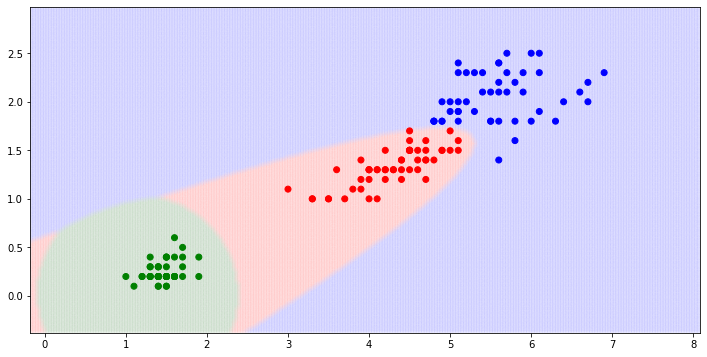

In [18]:
X_low, X_high = X.min(axis=0), X.max(axis=0)
delta = X_high - X_low
X_low -= delta * 0.2
X_high += delta * 0.2

X1, X2 = np.meshgrid(np.linspace(X_low[0], X_high[0], 256), 
                   np.linspace(X_low[1], X_high[1], 256))
Z = np.c_[X1.flatten(), X2.flatten()]
pred = gmm.predict(Z)
Z = np.exp(gmm.score_samples(Z))
Z = Z.reshape(X1.shape)

    
plt.scatter(X1.flatten(), X2.flatten(), c=list(np.array(colors)[pred]), alpha=0.01)
plt.scatter(X[:, 0], X[:, 1], c=list(np.array(colors)[gmm.predict(X)]))
plt.xlim(X_low[0], X_high[0])
plt.ylim(X_low[1], X_high[1])
plt.show()